In [10]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random

from pygents.aigents_api import TextMetrics, load_ngrams
from pygents.plot import plot_dict, plot_dict_bars, matrix_plot
from pygents.util import dictcount


In [11]:
from datasets import load_dataset

ds = load_dataset(
    "halilbabacan/combined_synthetic_cognitive_distortions",
    split="train",
)

df = ds.to_pandas()
df = df.rename(columns={'text': 'Patient Question', 'label': 'Dominant Distortion'})
df.insert(1, 'Distorted part', value = np.nan)
df.insert(3, 'Secondary Distortion (Optional)', value = np.nan)
# Remove the row with index 738 because it contains a NaN in the text column
df = df.drop(index=738)


mapping = {
    "Labelling":            "Labeling",
    "Mental Filter":        "Mental filter",
    "Should Statements":    "Should statements",
    "All-or-Nothing Thinking": "All-or-nothing thinking"
}

df['Dominant Distortion'] = df['Dominant Distortion'].map(mapping).fillna(df['Dominant Distortion'])

df

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,John walked past me without saying a word He m...,NaN,Mind Reading,NaN
1,"During the meeting, Sarah didn't look at me on...",NaN,Mind Reading,NaN
2,Mike didn't respond to my text right away He m...,NaN,Mind Reading,NaN
3,Jessica didn't smile when she saw me She must ...,NaN,Mind Reading,NaN
4,Tom didn't invite me to his party He must not ...,NaN,Mind Reading,NaN
...,...,...,...,...
4526,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
4527,Now I am at university my peers around me all ...,NaN,Overgeneralization,NaN
4528,He claims he’s severely depressed and has outb...,NaN,Mental filter,NaN
4529,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


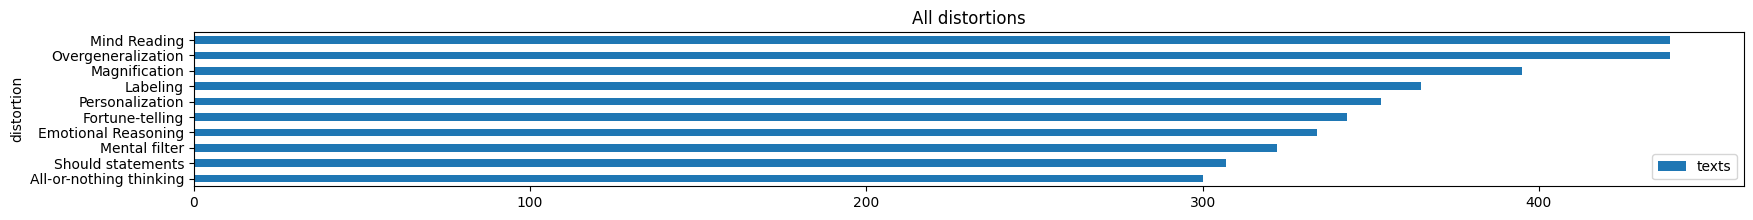

In [12]:
dists = {}
for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else 'No Distortion'  # The secondary distortion from the 4th column, if it exists
        ground_distortions = []
        if primary_distortion != 'No Distortion':
            ground_distortions.append(primary_distortion)
        if secondary_distortion != 'No Distortion':
            ground_distortions.append(secondary_distortion)
        for d in ground_distortions:
            dictcount(dists,d)
        
plot_dict(
    dists,
    labels="distortion",
    values="texts",
    title="All distortions",
    head=20
)

In [13]:
all_metrics = ['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Labeling',
          'Mind_Reading','Personalization','Emotional_Reasoning','Magnification','Should_statements']

def language_metrics(lang,metrics_list,path):
    metrics = {}
    for m in metrics_list:
        metrics[m] = path + lang + '/' + m + '.txt'
    return metrics

def our_evaluator_test(expected_distortions,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = True if (m in expected_distortions) else False
    return dic

def our_evaluator_tm(tm,text,threshold):
    metrics = tm.get_sentiment_words(text)
    dic = {}
    for m in all_metrics:
        dic[m] = True if m in metrics and metrics[m] > threshold else False
    return dic

def our_evaluator_true(tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = True
    return dic
    
def our_evaluator_false(tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = False
    return dic

def our_evaluator_random(tm,text,threshold):
    dic = {}
    for m in all_metrics:
        dic[m] = random.choice([True, False])
    return dic

def dictval(dic,key,val):
    return dic[key] if key in dic else val 

def pre_rec_f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return precision, recall, 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_tm_df(df,tm,evaluator,threshold,debug=False):
    true_positives = {}
    true_negatives = {}
    false_positives = {}
    false_negatives = {}
    pre = {}
    rec = {}
    f1 = {}
    acc = {}
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else 'No Distortion'  # The secondary distortion from the 4th column, if it exists
        ground_distortions = []
        if primary_distortion != 'No Distortion':
            ground_distortions.append(primary_distortion.replace(' ','_'))
        if secondary_distortion != 'No Distortion':
            ground_distortions.append(secondary_distortion.replace(' ','_'))

        if evaluator == our_evaluator_test:
            distortions_by_metric = evaluator(ground_distortions,text,threshold) #hack to test metrics
        else:
            distortions_by_metric = evaluator(tm,text,threshold)

        if debug:
            print(ground_distortions,'=>',[m for m in distortions_by_metric if distortions_by_metric[m]])
        
        for metric in distortions_by_metric:
            our_distortion = distortions_by_metric[metric]
            if (metric in ground_distortions) and our_distortion == True:
                dictcount(true_positives,metric)
            if (not metric in ground_distortions) and our_distortion == True:
                dictcount(false_positives,metric)
            if (not metric in ground_distortions) and our_distortion == False:
                dictcount(true_negatives,metric)
            if (metric in ground_distortions) and our_distortion == False:
                dictcount(false_negatives,metric)

    if debug:
        #print()
        print('TP:',true_positives)
        print('FP:',false_positives)
        print('TN:',true_negatives)
        print('FN:',false_negatives)
    
    for metric in all_metrics:
        precision, recall, f1score = pre_rec_f1_from_counts(dictval(true_positives,metric,0), dictval(true_negatives,metric,0), 
                                   dictval(false_positives,metric,0), dictval(false_negatives,metric,0))
        pre[metric] = precision
        rec[metric] = recall
        f1[metric] = f1score
        acc[metric] = (dictval(true_positives,metric,0) + dictval(true_negatives,metric,0)) / len(df)
    
    return pre, rec, f1, acc


def matrix_plot(row_labels, col_labels, matrix, absmax, title = None, vmin = None, vmax = None, dpi = None, titlefontsize = None, width = 20):
    plt.rcParams["figure.figsize"] = (width,len(row_labels)/4)
    if not dpi is None:
        plt.rcParams["figure.dpi"] = dpi
    p = sns.heatmap(matrix, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin = -absmax if vmin is None else vmin, 
                    vmax = absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        p.set_title(title,fontsize = titlefontsize)
    plt.show()


In [14]:
models = {}

models['Ours new (multi-class, joint), log'] = TextMetrics(language_metrics('',all_metrics,
                                            path='./data/models/distortions/split_combined/multiclass_view_cleaned/joint/'),
                                            encoding="utf-8",metric_logarithmic=True,debug=False)

models['Ours new (multi-class, joint), no log'] = TextMetrics(language_metrics('',all_metrics,
                                            path='./data/models/distortions/split_combined/multiclass_view_cleaned/joint/'),
                                            encoding="utf-8",metric_logarithmic=False,debug=False)


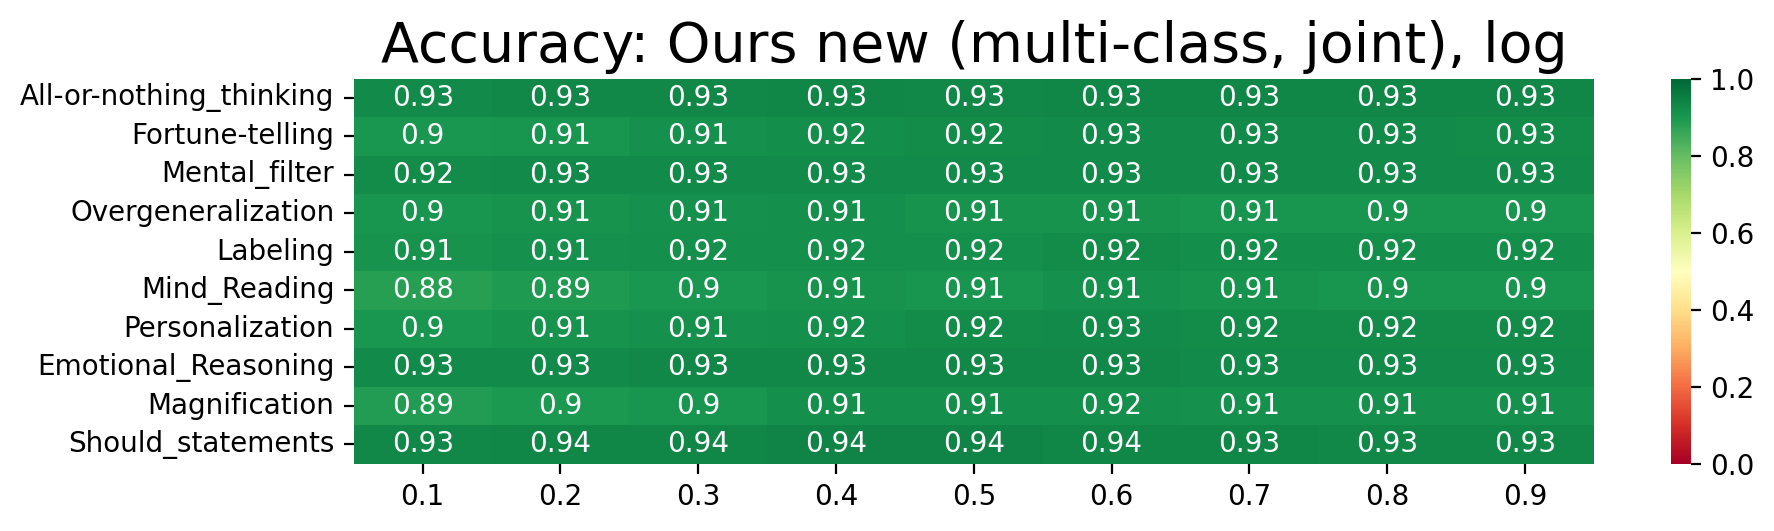

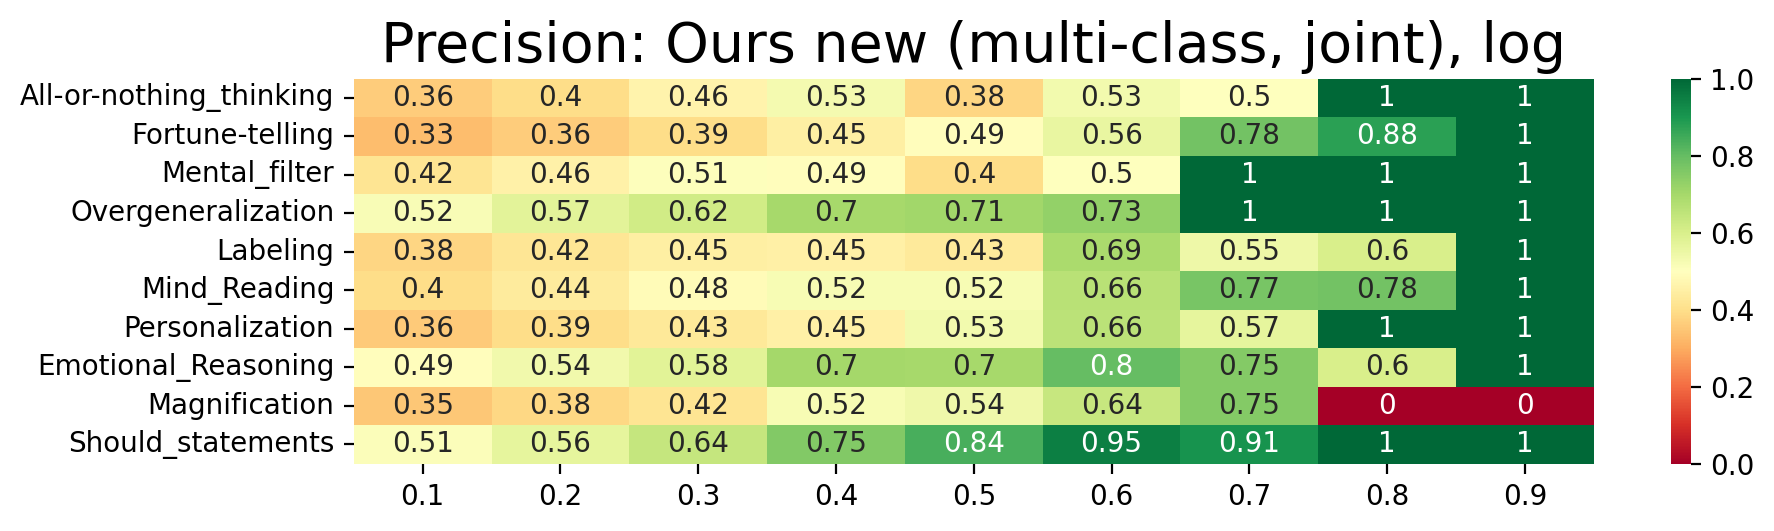

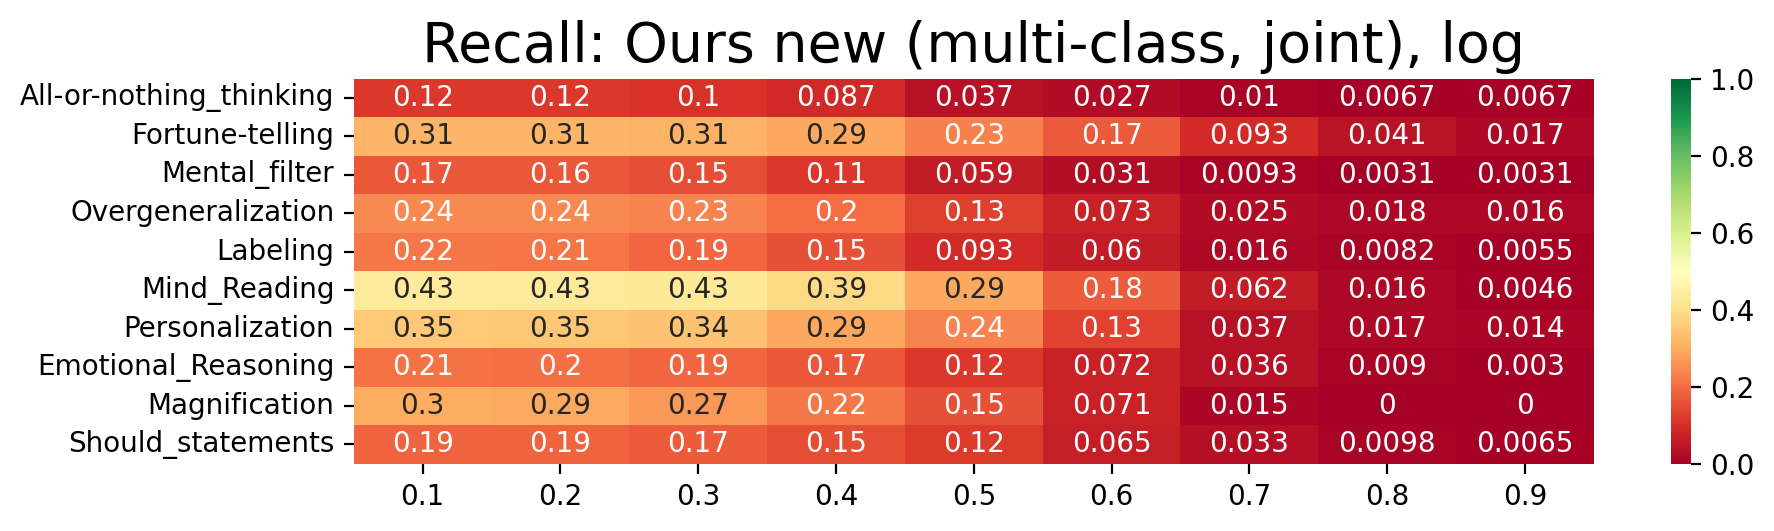

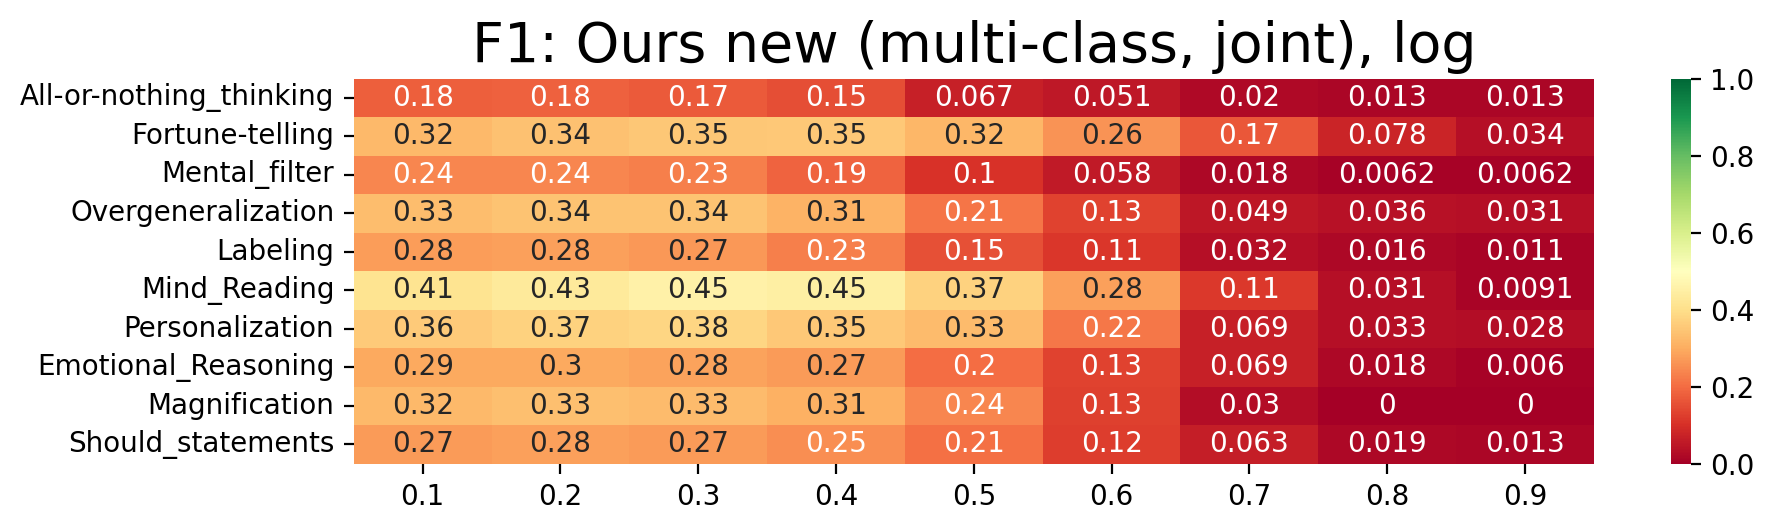

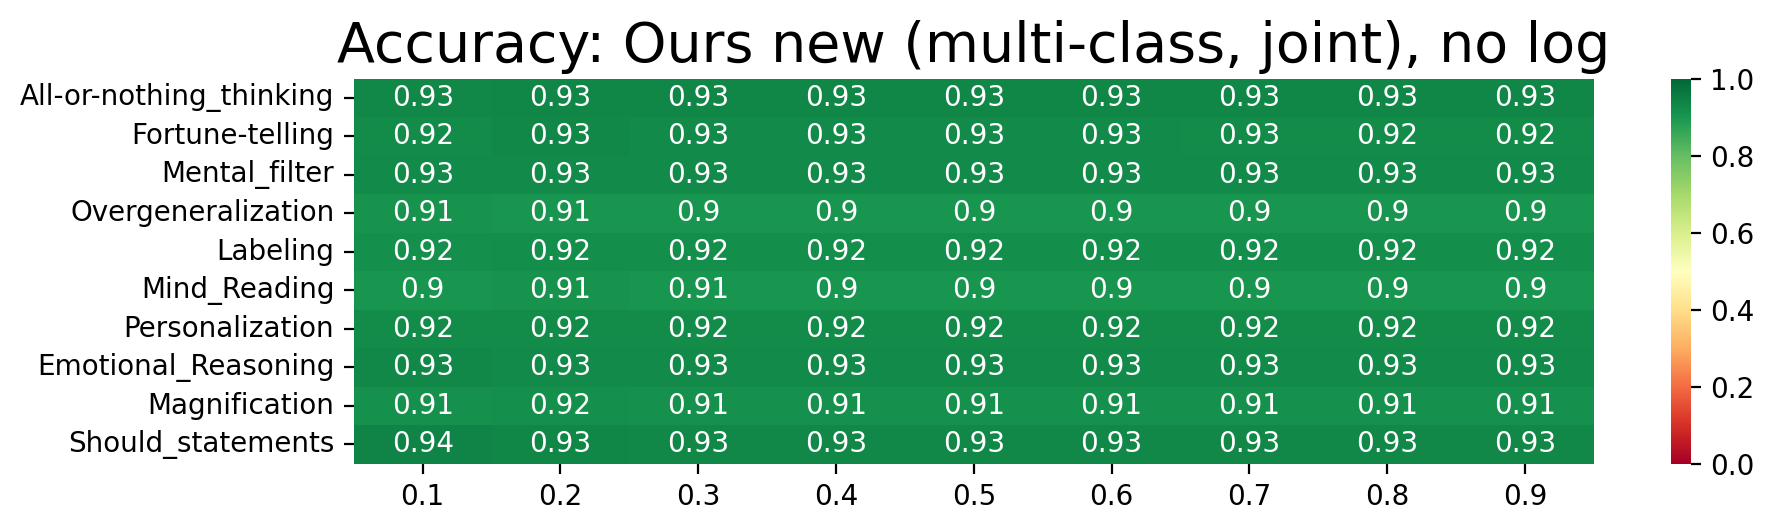

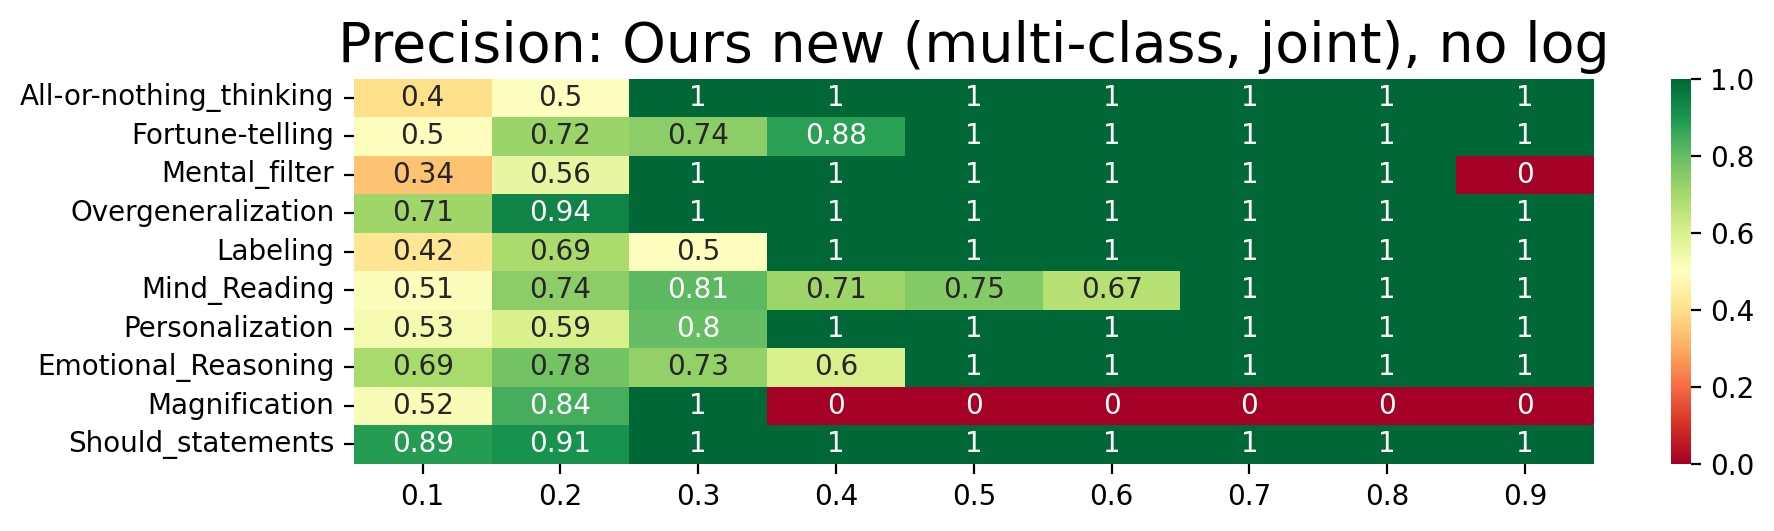

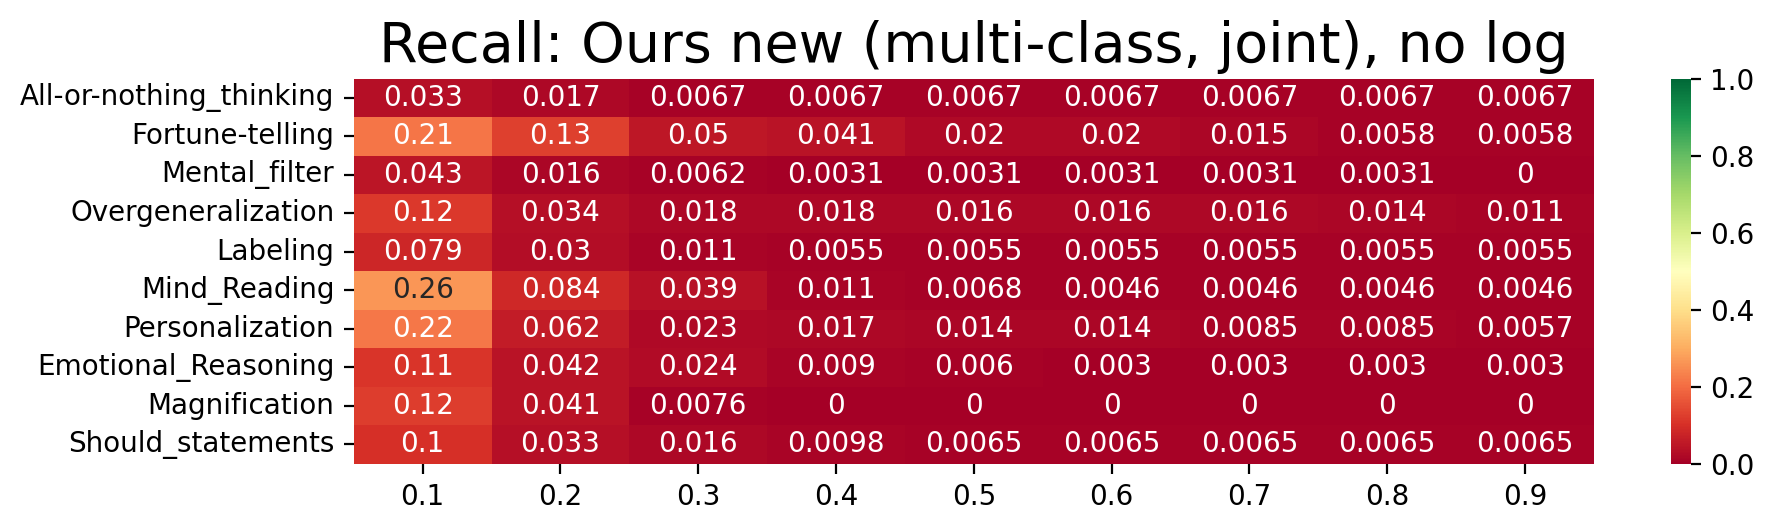

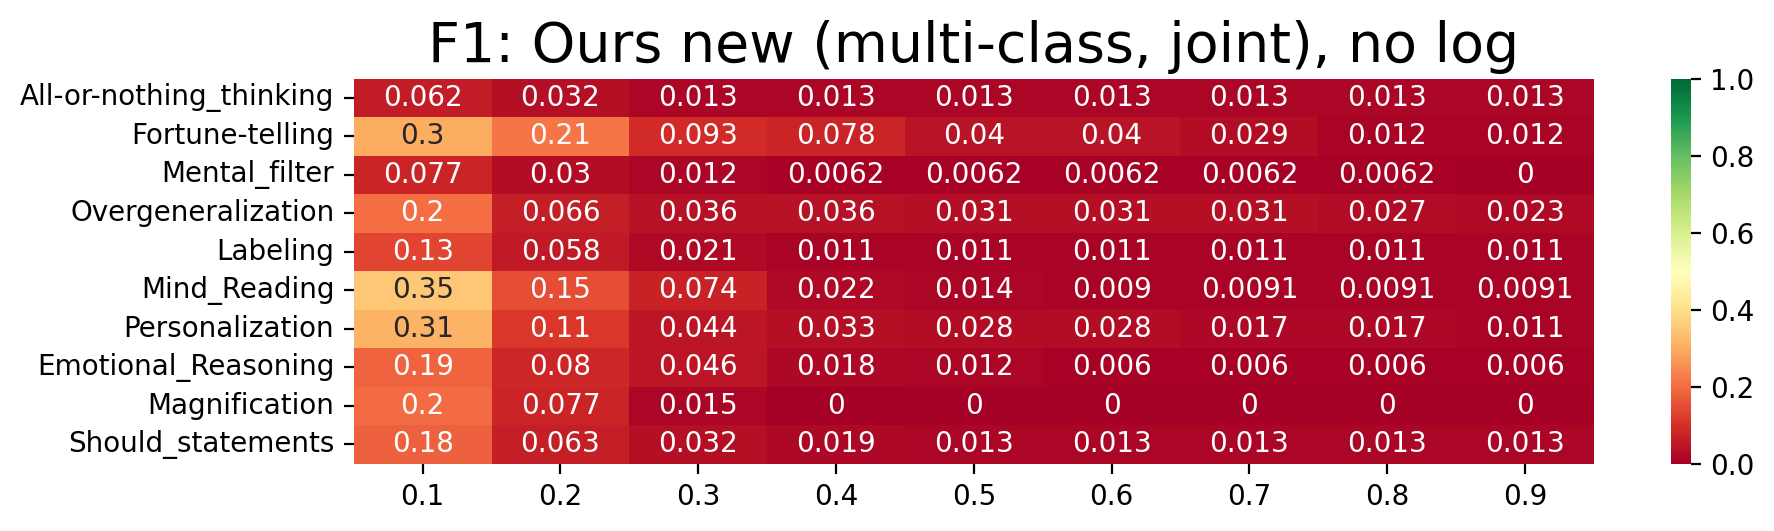

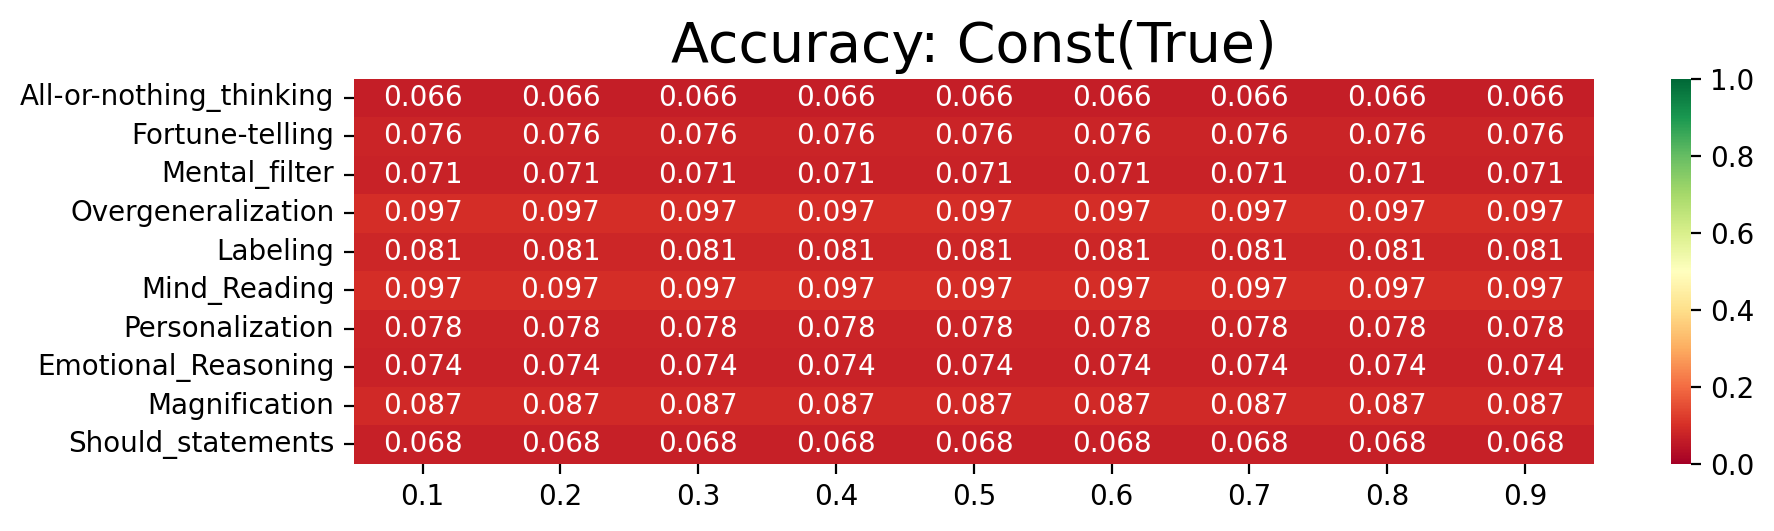

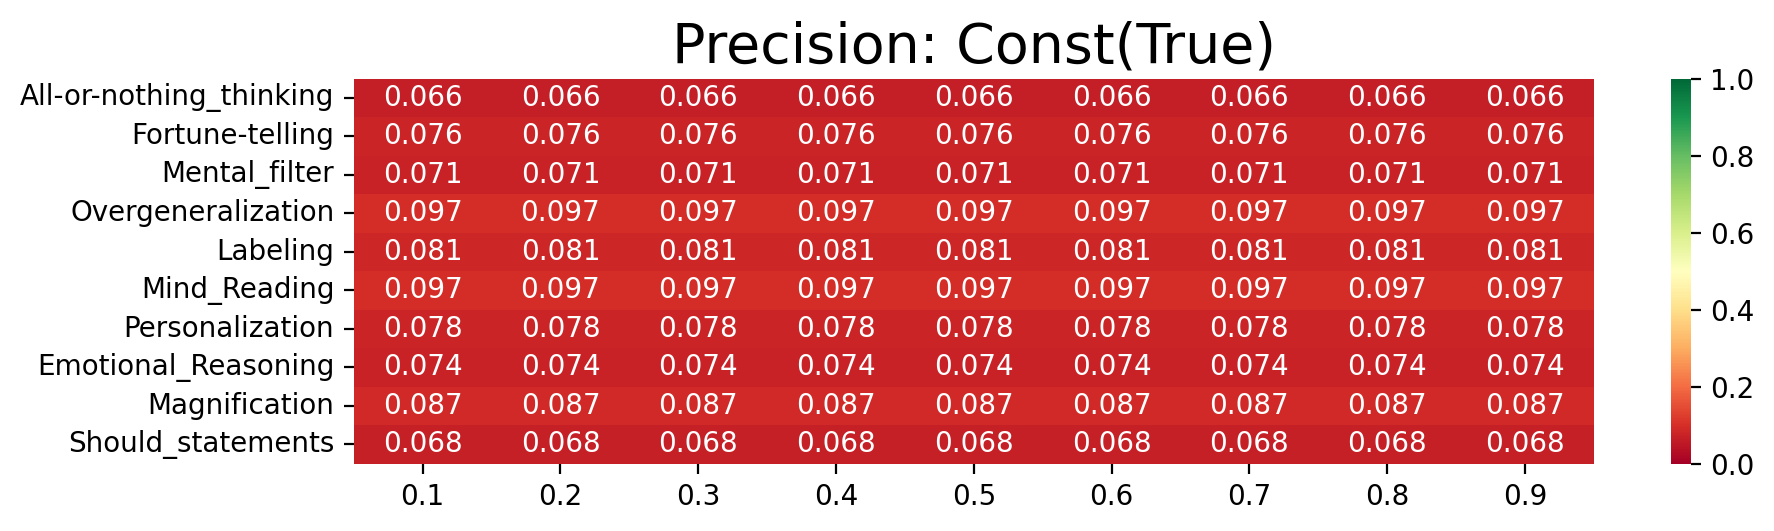

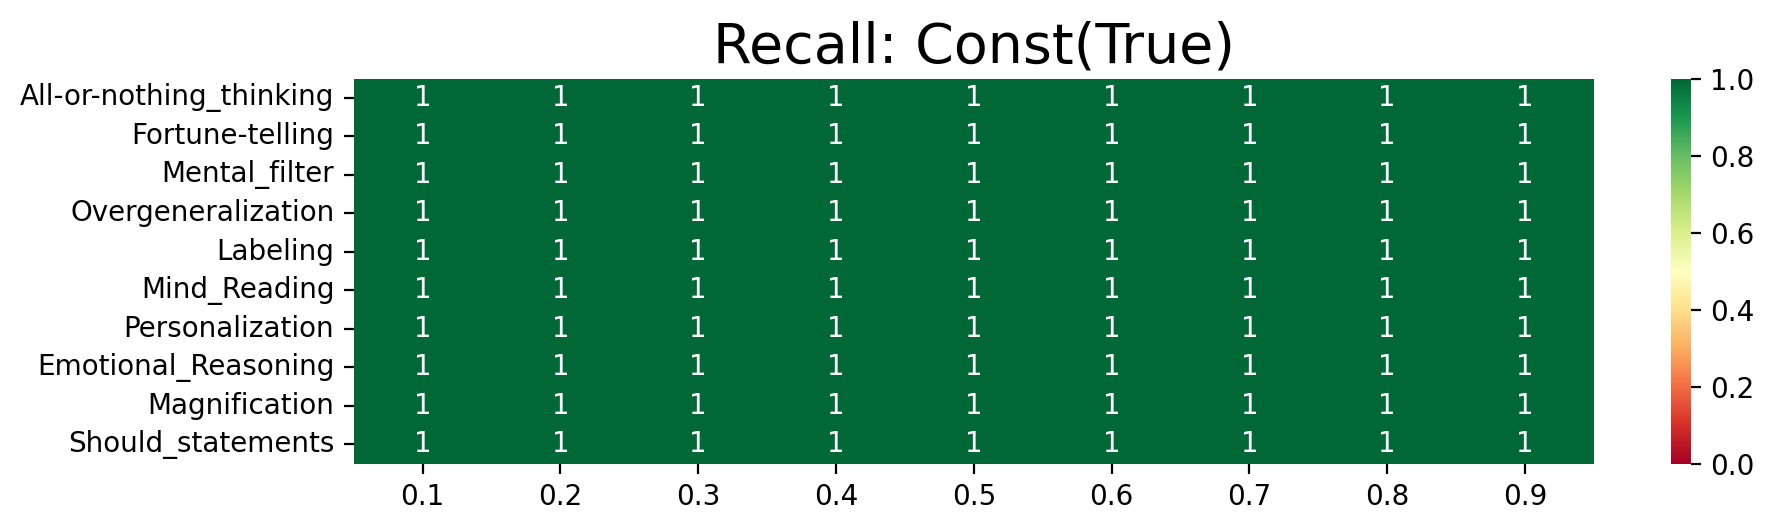

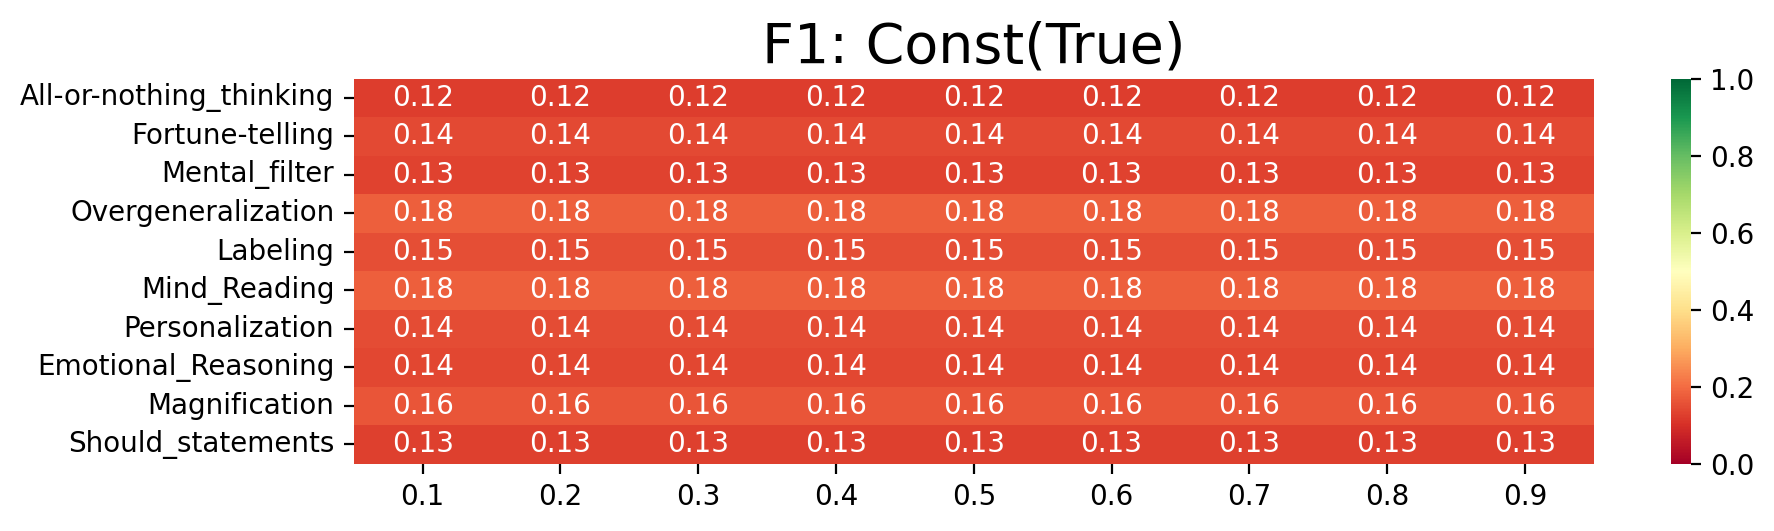

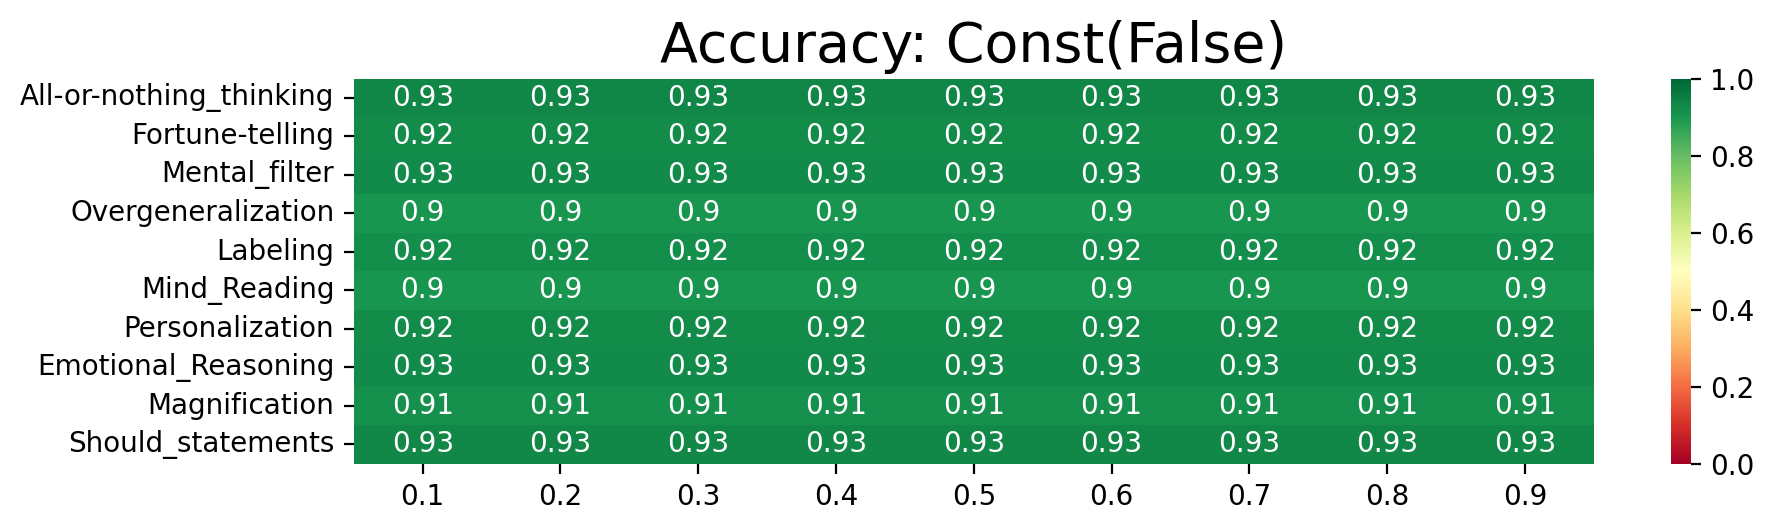

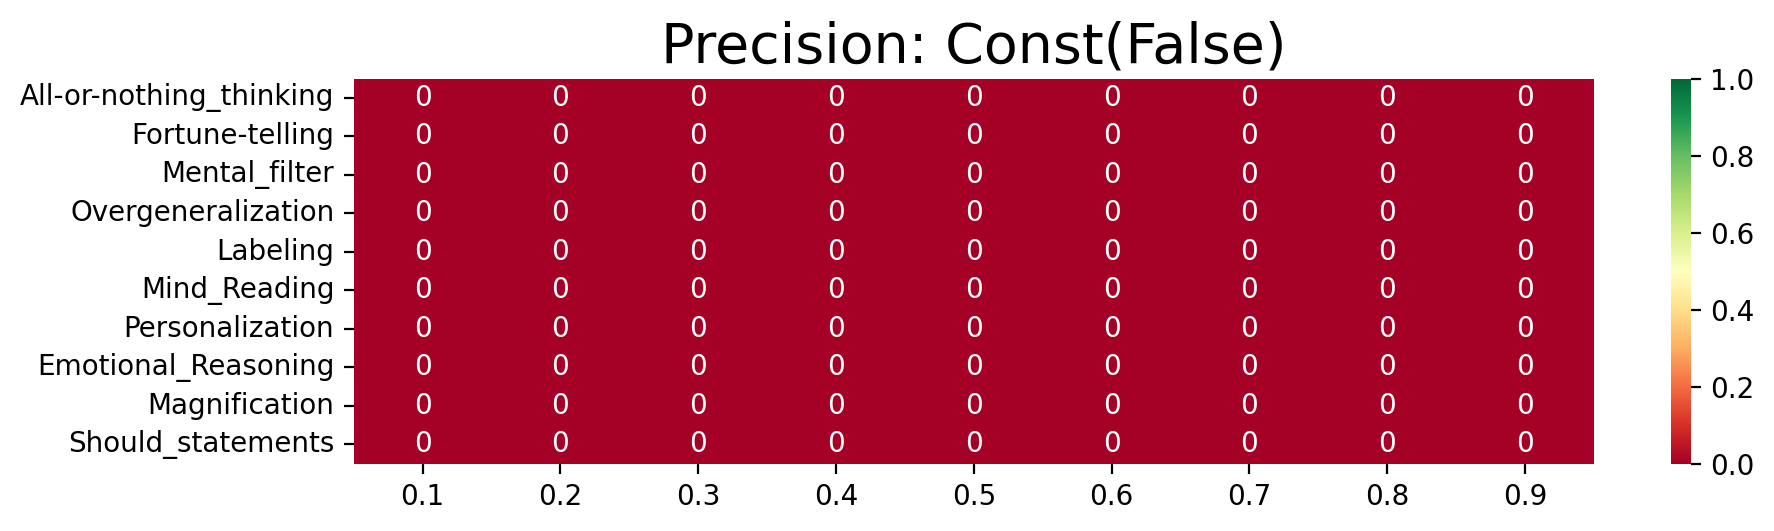

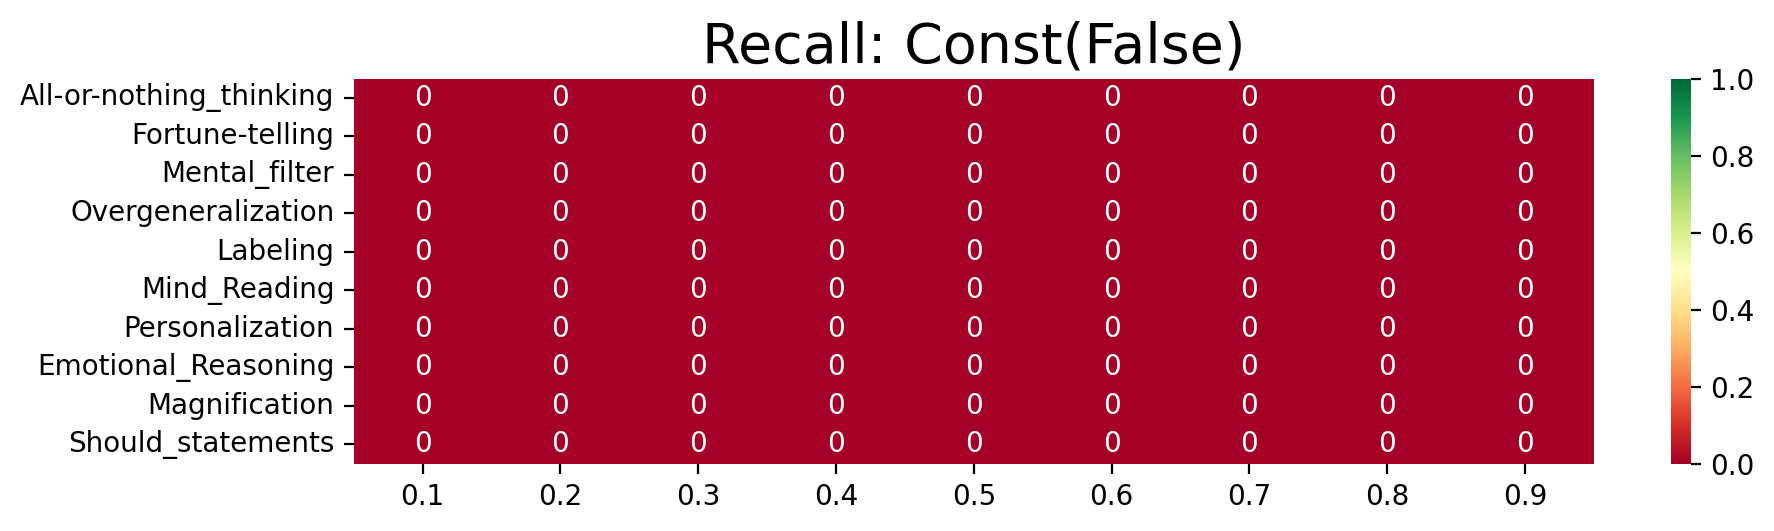

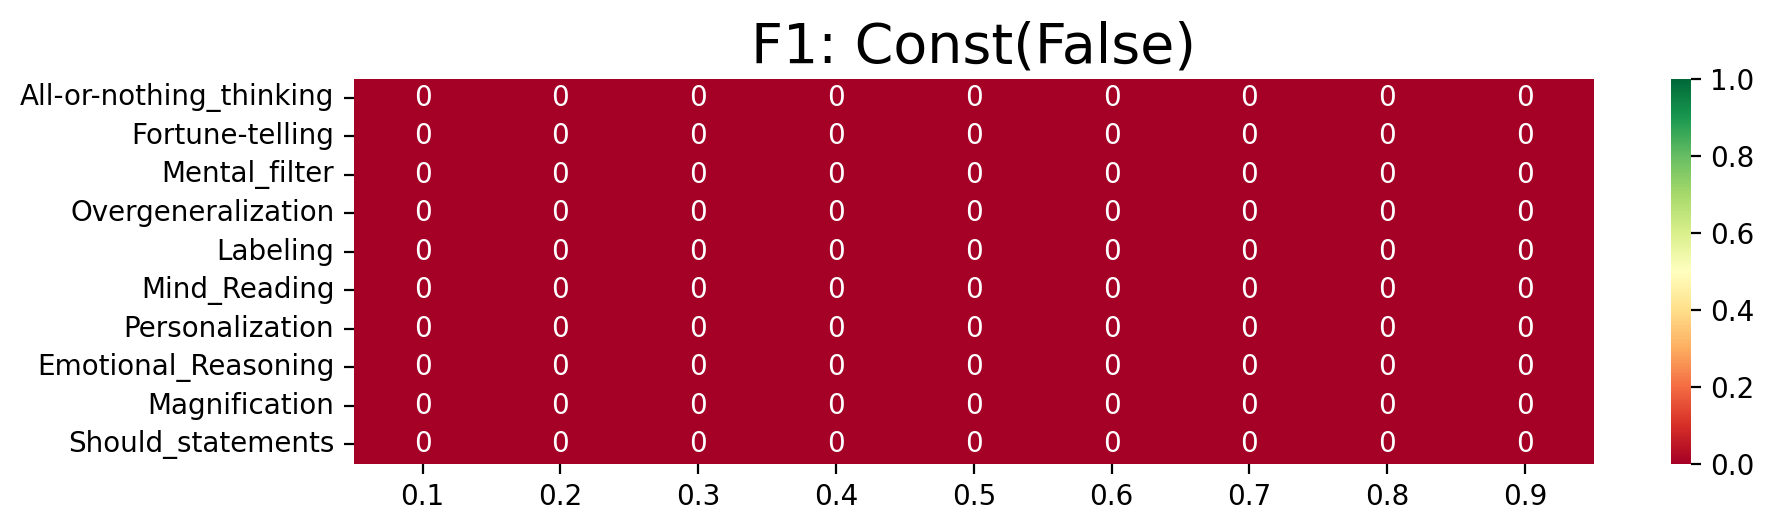

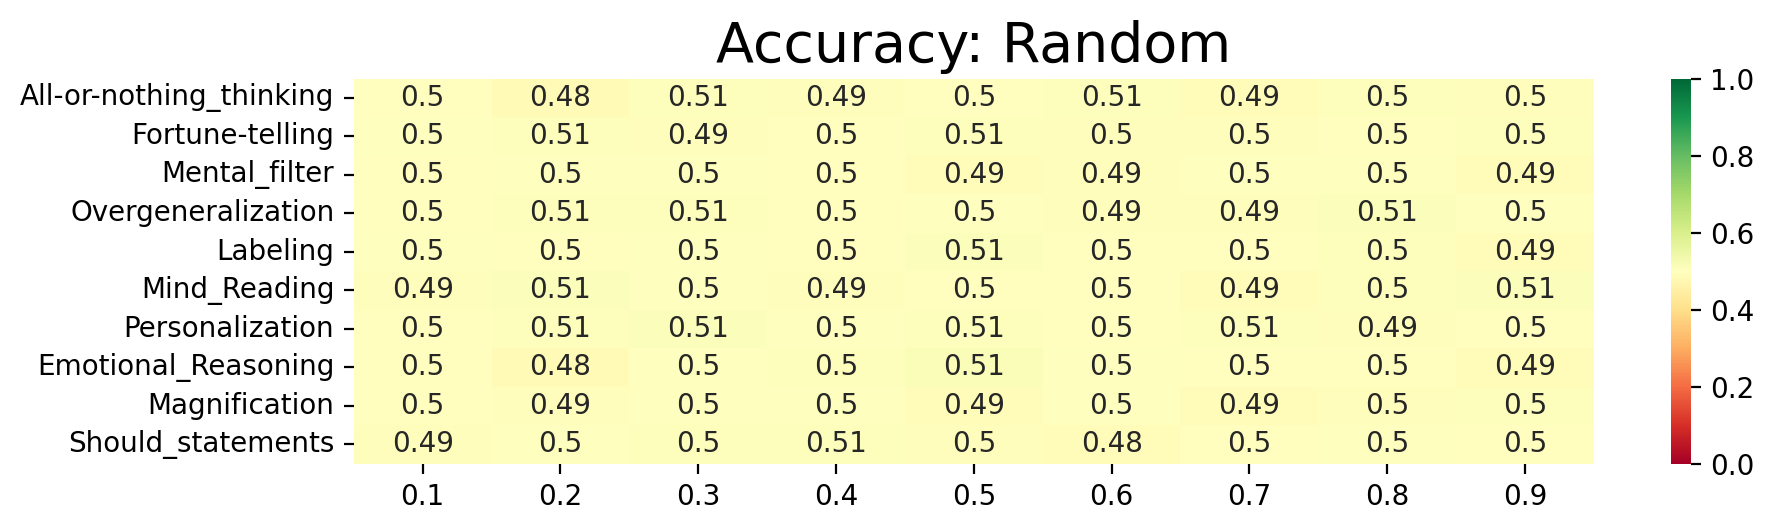

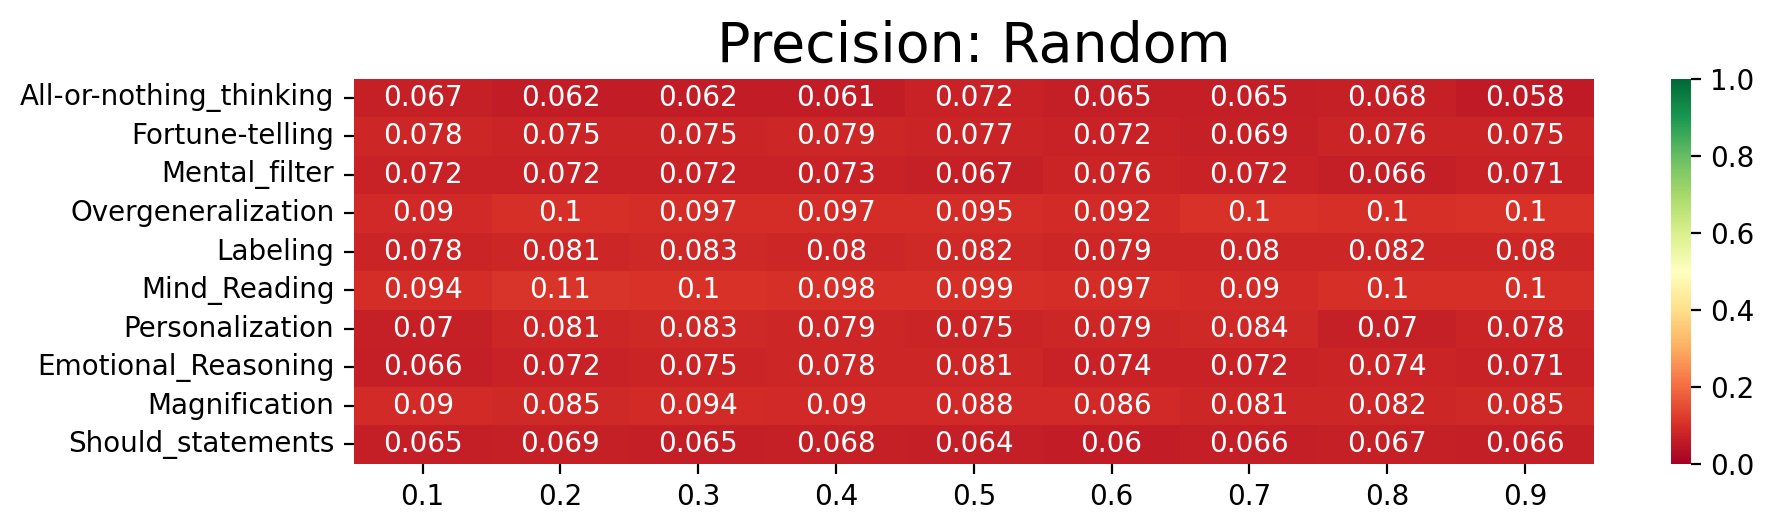

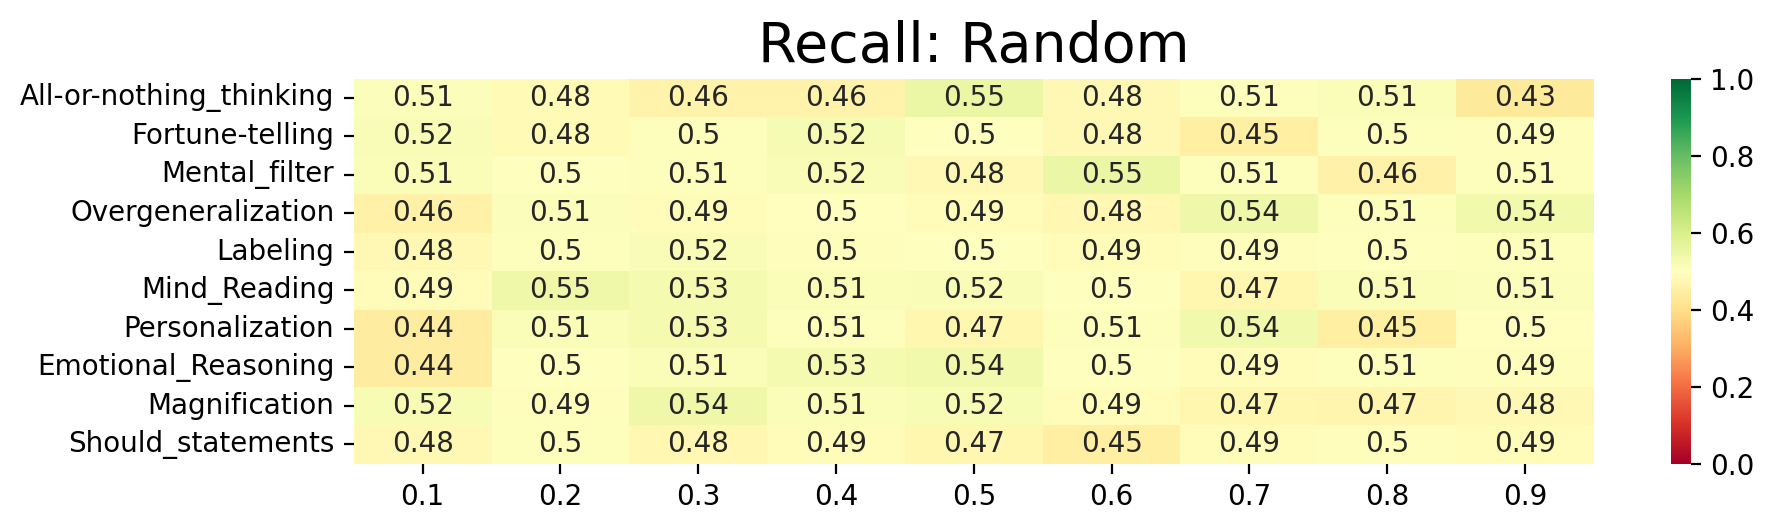

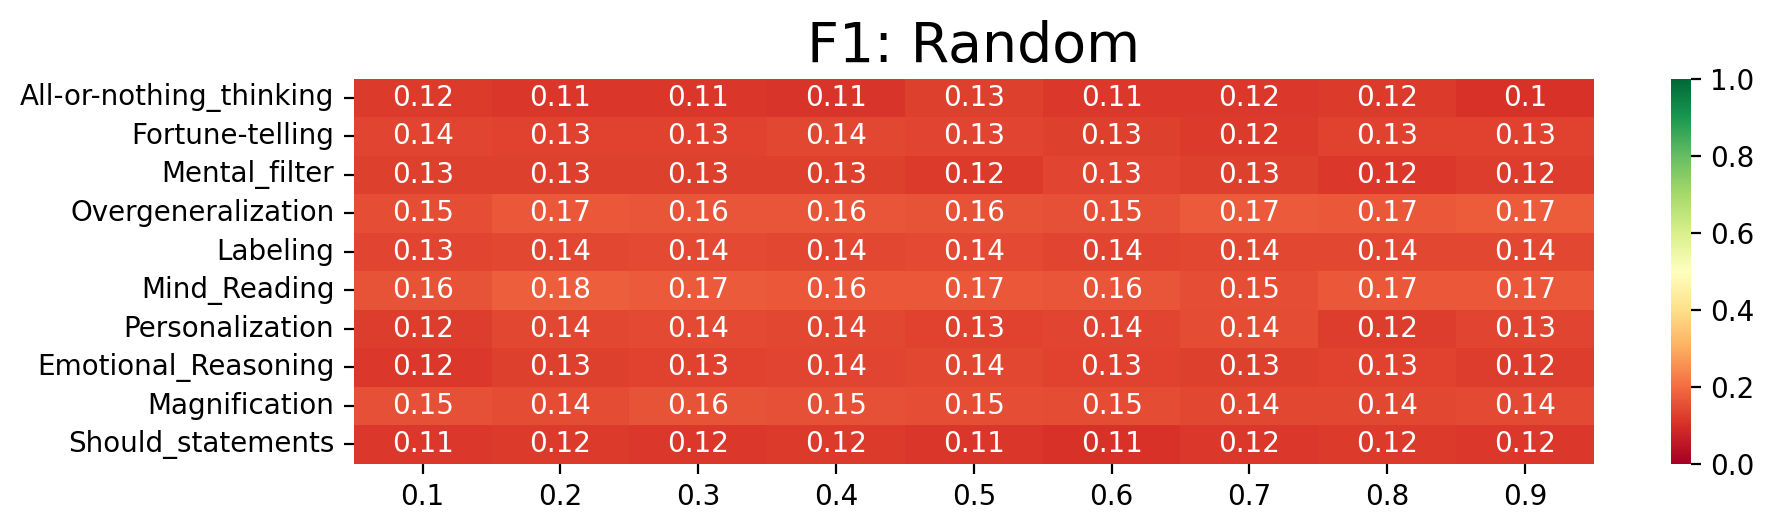

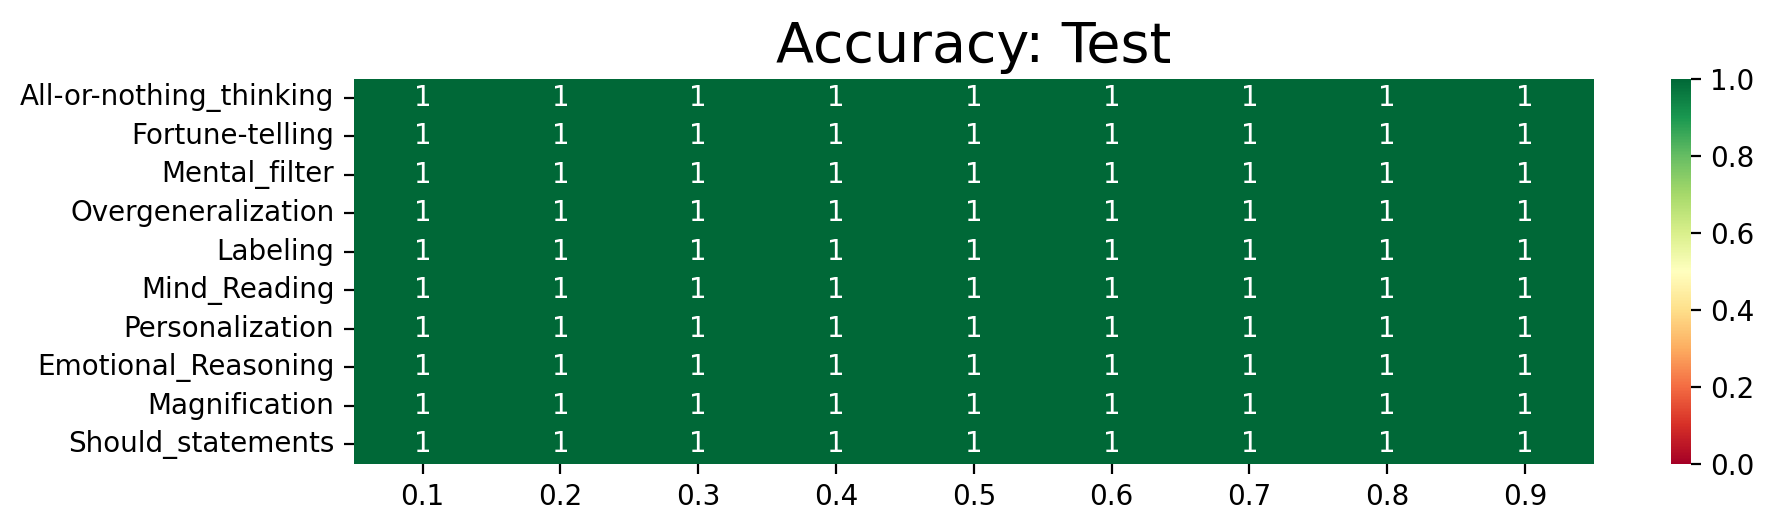

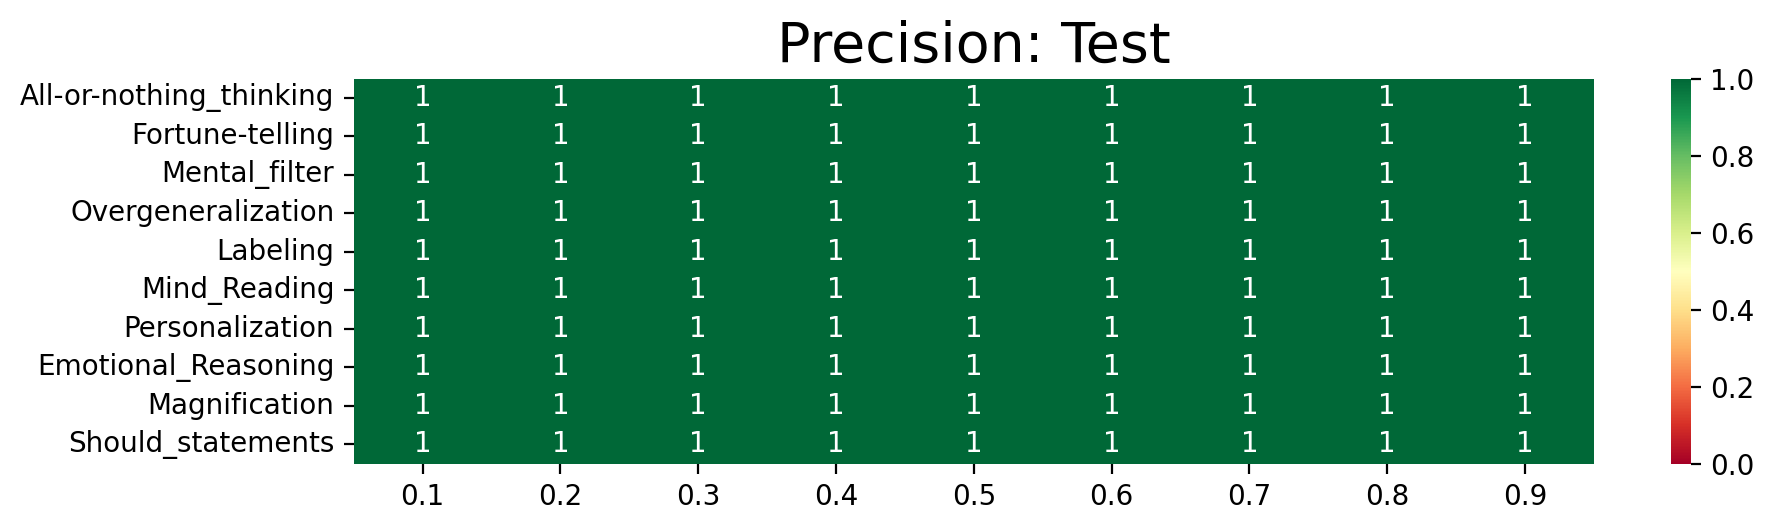

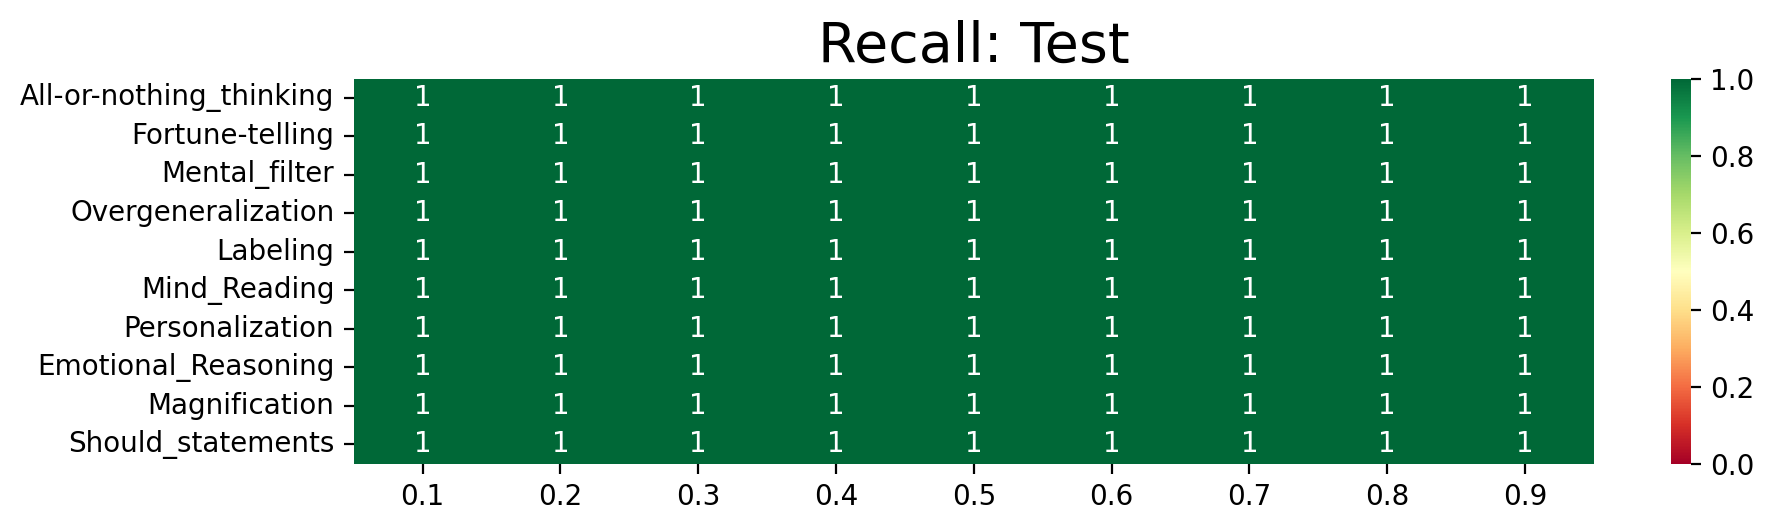

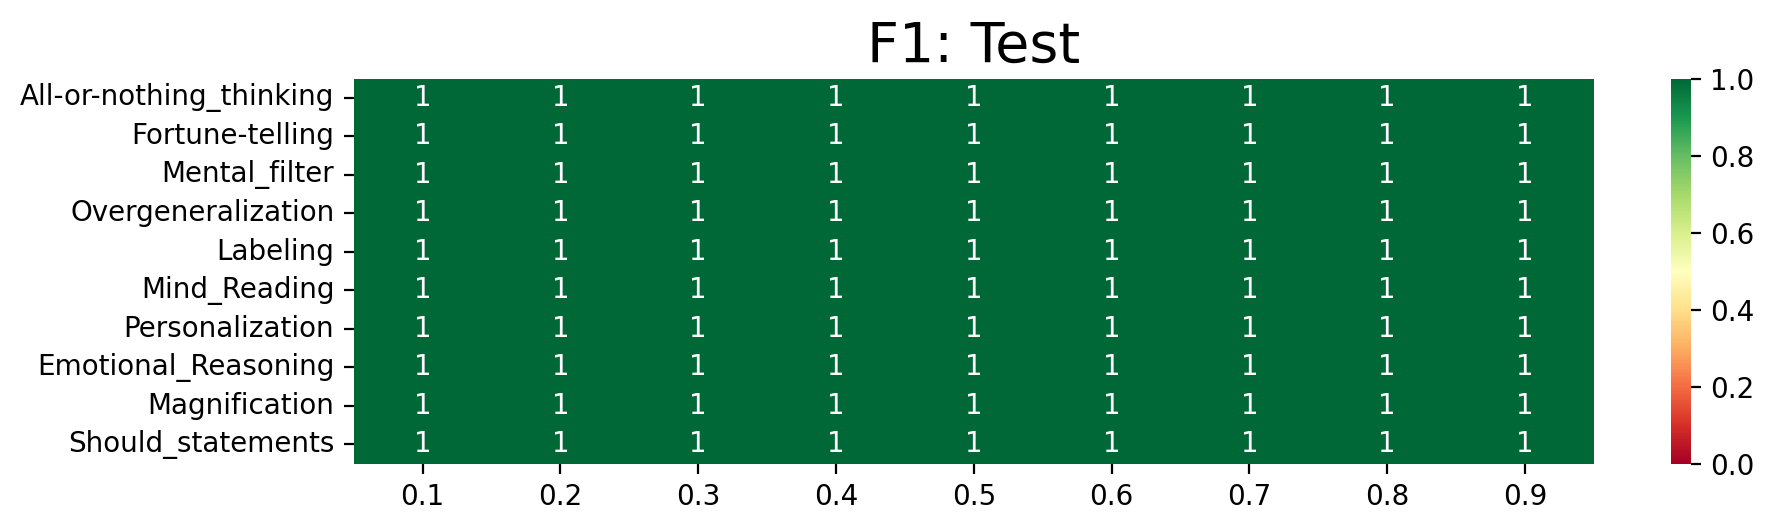

In [15]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
#thresholds = [0.1]

evaluators = {
    'Ours new (multi-class, joint), log': our_evaluator_tm,
    'Ours new (multi-class, joint), no log': our_evaluator_tm,
    'Const(True)': our_evaluator_true,
    'Const(False)': our_evaluator_false,
    'Random': our_evaluator_random,
    'Test': our_evaluator_test,
}

#for model in ['Ours new (multi-class, joint), log']:
for model in ['Ours new (multi-class, joint), log', 'Ours new (multi-class, joint), no log', 'Const(True)','Const(False)','Random','Test']:
#for model in ['Const(True)','Const(False)','Test']:
#for model in ['Const(False)']:
    pres = [[] for i in range(len(all_metrics))]
    recs = [[] for i in range(len(all_metrics))]
    f1s = [[] for i in range(len(all_metrics))]
    accs = [[] for i in range(len(all_metrics))]
    evaluator = evaluators[model]
    for t in thresholds:
        pre, rec, f1, acc = evaluate_tm_df(df,models[model] if model in models else None,evaluator,t,debug=False)
        mi = 0
        for metric in all_metrics:
            pres[mi].append(pre[metric])
            recs[mi].append(rec[metric])
            f1s[mi].append(f1[metric])
            accs[mi].append(acc[metric])
            mi += 1
    
    matrix_plot(all_metrics, thresholds, accs, 1.0, title = f'Accuracy: {model}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

    matrix_plot(all_metrics, thresholds, pres, 1.0, title = f'Precision: {model}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

    matrix_plot(all_metrics, thresholds, recs, 1.0, title = f'Recall: {model}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

    matrix_plot(all_metrics, thresholds, f1s, 1.0, title = f'F1: {model}', vmin = 0, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)


In [16]:
# TODO

# 1) How do they get F1 0.95 on multi-class!?
# https://dergipark.org.tr/tr/pub/fumbd/issue/88821/1469178

# 2) Perform cross-split validation experiment with our "BEST" learning parameters

# 3) Compute average F1 with "error bars" on 
# a) "joint" on three splits
# b) cross-split on three splits

# 4) Test on "theirs" https://dergipark.org.tr/tr/pub/fumbd/issue/88821/1469178 synthetic dataset only!?

